# Investigating The Efficacy of Data Profiles in the Prediction of Pulsar Star Class.

## Introduction

A pulsar star is a neutron star with a high mass that emits electromagnetic radiation when it collapses. This emission of radiation can be detected as radio waves by telescopes thus giving them a unique integrated pulse profile and DM-SNR curve. These profiles can be used to classify a signal as either pulsar or non-pulsar.

### Main Question

Does the integrated pulse profile or the DM-SNR curve better predict whether an emission signal is from a pulsar star? 

### The Dataset

This dataset (https://archive.ics.uci.edu/ml/datasets/HTRU2) represents a collection of observed radio emissions that have been confirmed to be either from pulsar stars (Class 1), or a mix of radio frequency interference (RFI) and noise (Class 0).  
Each observation contains a mean, standard deviation, kurtosis, and skewness of emissions averaged over multiple rotations of the potential pulsar star. This makes up the integrated profile (IP).  
Each observation also contains a transformed mean, standard deviation, kurtosis, and skewness of the emissions based on the dispersion measure (DM) to maximize the signal-to-noise ratio. These make up the DM-SNR variables.


In [1]:
library(plyr)
library(tidyverse)
library(repr)
library(tidymodels)
#install.packages("themis")
source('tests.R')
source('cleanup.R')

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()   masks plyr::arrange()
✖ purrr::compact()   masks plyr::compact()
✖ dplyr::count()     masks plyr::count()
✖ dplyr::failwith()  masks plyr::failwith()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::id()        masks plyr::id()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::mutate()    masks plyr::mutate()
✖ dplyr::rename()    masks plyr::rename()
✖ dplyr::summarise() masks plyr::summarise()
✖ dplyr::summarize() masks plyr::summarize()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ mod

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [2]:
#Reading the data: Here, we read the dataset from the web into R, 
# and loaded the dataset to examine it.
options(repr.matrix.max.rows = 6)
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"
download.file(url, "HTRU2.zip") 
unzip("HTRU2.zip")
pulsar_data_raw <- read_csv('HTRU_2.csv') 
pulsar_data_raw


Rows: 17897 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): 140.5625, 55.68378214, -0.234571412, -0.699648398, 3.199832776, 19....

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


140.5625,55.68378214,-0.234571412,-0.699648398,3.199832776,19.11042633,7.975531794,74.24222492,0
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
102.5078,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.0156,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.7500,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
119.3359,59.93594,0.1593631,-0.74302540,21.430602,58.87200,2.499517,4.595173,0
114.5078,53.90240,0.2011614,-0.02478884,1.946488,13.38173,10.007967,134.238910,0
57.0625,85.79734,1.4063910,0.08951971,188.306020,64.71256,-1.597527,1.429475,0


## Tidying and preparing the Data:

In [3]:
# Here, we tidied and wrangled the data set using these steps: 
# a) Giving names to columns 
# b) Changing the Class labels from 0 and 1 to "Non-pulsar" and "Pulsar", respectively 
# c) Splitting the data into the IP and DM-SNR profiles
# d) Spitting each profile into a training and test set


options(repr.matrix.max.rows = 6)
col_names <- c('Mean_IP', 'Stdev_IP', 'Kurtosis_IP', 'Skewness_IP', 
               'Mean_DM', "Stdev_DM", 'Kurtosis_DM', "Skewness_DM", "Class")
pulsar_data <- read_csv('HTRU_2.csv', col_names)

pulsar_data_wrangled <- mutate(pulsar_data, Class = as.character(Class))

pulsar_data_wrangled$Class[pulsar_data_wrangled$Class == '0'] <- "Non-pulsar"
pulsar_data_wrangled$Class[pulsar_data_wrangled$Class == '1'] <- "Pulsar"

pulsar_data_IP <- select(pulsar_data_wrangled, Mean_IP, Stdev_IP, Kurtosis_IP, Skewness_IP, Class)

IP_split <- initial_split(pulsar_data_IP, prop = 0.75, strata = Class)
IP_train <- training(IP_split)
IP_test <- testing(IP_split) 

IP_train

pulsar_data_DM <- select(pulsar_data_wrangled, Mean_DM, Stdev_DM, Kurtosis_DM, Skewness_DM, Class)

DM_split <- initial_split(pulsar_data_DM, prop = 0.75, strata = Class)
DM_train <- training(DM_split)
DM_test <- testing(DM_split) 

DM_train


Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Mean_IP, Stdev_IP, Kurtosis_IP, Skewness_IP, Mean_DM, Stdev_DM, Kur...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Mean_IP,Stdev_IP,Kurtosis_IP,Skewness_IP,Class
<dbl>,<dbl>,<dbl>,<dbl>,<chr>
140.5625,55.68378,-0.2345714,-0.6996484,Non-pulsar
102.5078,58.88243,0.4653182,-0.5150879,Non-pulsar
103.0156,39.34165,0.3233284,1.0511644,Non-pulsar
⋮,⋮,⋮,⋮,⋮
119.3359,59.93594,0.1593631,-0.74302540,Non-pulsar
114.5078,53.90240,0.2011614,-0.02478884,Non-pulsar
57.0625,85.79734,1.4063910,0.08951971,Non-pulsar


Mean_DM,Stdev_DM,Kurtosis_DM,Skewness_DM,Class
<dbl>,<dbl>,<dbl>,<dbl>,<chr>
3.199833,19.11043,7.975532,74.24222,Non-pulsar
3.121237,21.74467,7.735822,63.17191,Non-pulsar
3.642977,20.95928,6.896499,53.59366,Non-pulsar
⋮,⋮,⋮,⋮,⋮
1.296823,12.16606,15.450260,285.931022,Non-pulsar
1.946488,13.38173,10.007967,134.238910,Non-pulsar
188.306020,64.71256,-1.597527,1.429475,Non-pulsar


## Summary Table of Each Dataset:

In [4]:
#We created a table of the means, standard deviations, kurtosis, 
# and skewness of the integrated and the DM-SNR puslar profiles.

IP_train_summary <- group_by(IP_train, Class) |>
    summarize(avg_mean_ip = mean(Mean_IP), avg_stdev_ip = mean(Stdev_IP), 
              avg_kurtosis_ip = mean(Kurtosis_IP), avg_skewness_ip = mean(Skewness_IP),
              count = n(), percentage = (n() / nrow(IP_train)) * 100) 
IP_train_summary

DM_train_summary <- group_by(DM_train, Class) |>
    summarize(avg_mean_dm = mean(Mean_DM), avg_stdev_dm = mean(Stdev_DM), 
              avg_kurtosis_dm = mean(Kurtosis_DM), avg_skewness_dm = mean(Skewness_DM),
              count = n(), percentage = (n() / nrow(DM_train)) * 100)
DM_train_summary

Class,avg_mean_ip,avg_stdev_ip,avg_kurtosis_ip,avg_skewness_ip,count,percentage
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
Non-pulsar,116.71036,47.33977,0.2083722,0.3768146,12164,90.620577
Pulsar,56.34016,38.66159,3.1667522,15.8729846,1259,9.379423


Class,avg_mean_dm,avg_stdev_dm,avg_kurtosis_dm,avg_skewness_dm,count,percentage
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
Non-pulsar,8.920182,23.41736,8.829450,112.74214,12203,90.911123
Pulsar,49.304627,55.92068,2.806962,18.56252,1220,9.088877


## Visualizing the data


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




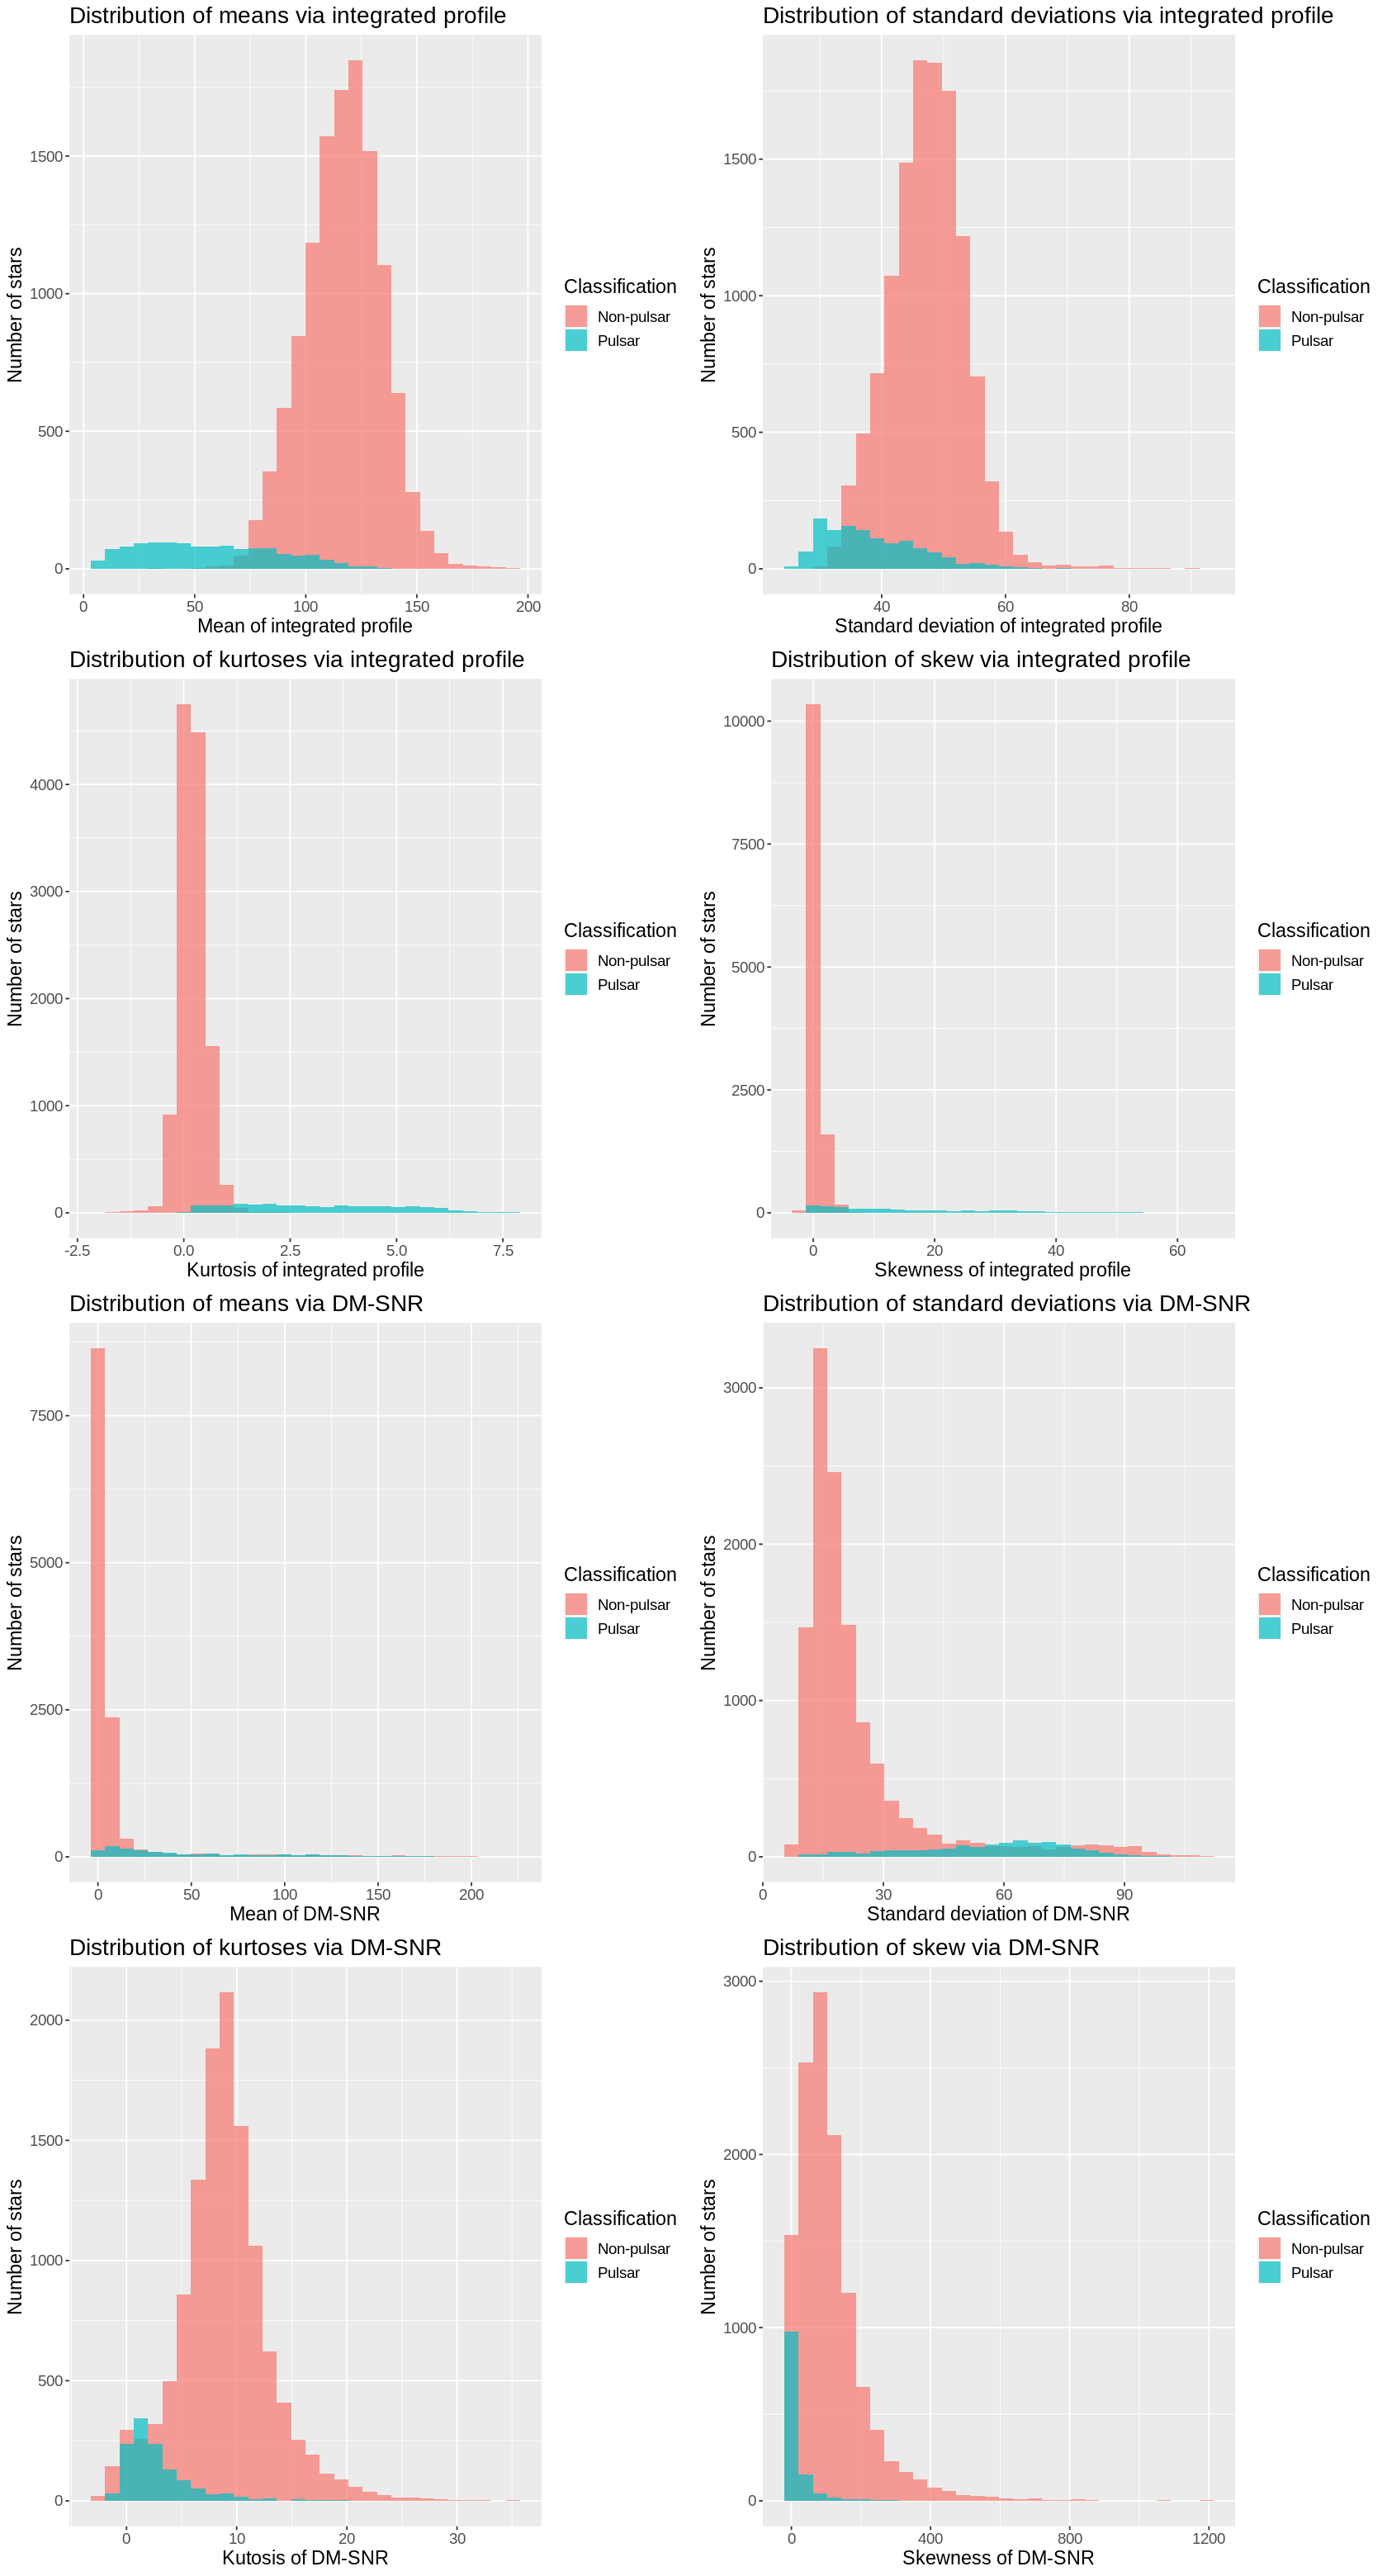

In [5]:
#We visualized the distributions of means, SD, 
# kurtoses and skewness for the integrated and DM-SNR profiles.

library(gridExtra)
library(grid)
library(lattice)

options(repr.plot.width = 14, repr.plot.height = 26) 

pulsar_hist_mean_IP <- ggplot(IP_train, aes(x = Mean_IP, fill = Class)) +
    geom_histogram(alpha = 0.7, position = "identity", bins = 30) +
    theme(text = element_text(size = 14)) +
    labs(x="Mean of integrated profile", 
         y= "Number of stars", 
         fill = "Classification", 
         title = 'Distribution of means via integrated profile')

pulsar_hist_SD_IP <- ggplot(IP_train, aes(x = Stdev_IP, fill = Class)) +
    geom_histogram(alpha = 0.7, position = "identity", bins = 30) +
    theme(text = element_text(size = 14)) +
    labs(x="Standard deviation of integrated profile", 
         y= "Number of stars", 
         fill = "Classification", 
         title = 'Distribution of standard deviations via integrated profile')

pulsar_hist_Kurtosis_IP <- ggplot(IP_train, aes(x = Kurtosis_IP, fill = Class)) +
    geom_histogram(alpha = 0.7, position = "identity", bins = 30) +
    theme(text = element_text(size = 14)) +
    labs(x="Kurtosis of integrated profile", 
         y= "Number of stars", 
         fill = "Classification", 
         title = 'Distribution of kurtoses via integrated profile')

pulsar_hist_Skew_IP <- ggplot(IP_train, aes(x = Skewness_IP, fill = Class)) +
    geom_histogram(alpha = 0.7, position = "identity", bins = 30) +
    theme(text = element_text(size = 14)) +
    labs(x="Skewness of integrated profile", 
         y= "Number of stars", 
         fill = "Classification", 
         title = 'Distribution of skew via integrated profile')


pulsar_hist_mean_DM <- ggplot(DM_train, aes(x = Mean_DM, fill = Class)) +
    geom_histogram(alpha = 0.7, position = "identity", bins = 30) +
    theme(text = element_text(size = 14)) +
    labs(x="Mean of DM-SNR", 
         y= "Number of stars", 
         fill = "Classification", 
         title = 'Distribution of means via DM-SNR')

pulsar_hist_SD_DM <- ggplot(DM_train, aes(x = Stdev_DM, fill = Class)) +
    geom_histogram(alpha = 0.7, position = "identity", bins = 30) +
    theme(text = element_text(size = 14)) +
    labs(x="Standard deviation of DM-SNR", 
         y= "Number of stars", 
         fill = "Classification", 
         title = 'Distribution of standard deviations via DM-SNR')

pulsar_hist_Kurtosis_DM <- ggplot(DM_train, aes(x = Kurtosis_DM, fill = Class)) +
    geom_histogram(alpha = 0.7, position = "identity", bins = 30) +
    theme(text = element_text(size = 14)) +
    labs(x="Kutosis of DM-SNR", 
         y= "Number of stars", 
         fill = "Classification", 
         title = 'Distribution of kurtoses via DM-SNR')

pulsar_hist_Skew_DM <- ggplot(DM_train, aes(x = Skewness_DM, fill = Class)) +
    geom_histogram(alpha = 0.7, position = "identity", bins = 30) +
    theme(text = element_text(size = 14)) +
    labs(x="Skewness of DM-SNR", 
         y= "Number of stars", 
         fill = "Classification", 
         title = 'Distribution of skew via DM-SNR')

grid.arrange(pulsar_hist_mean_IP, pulsar_hist_SD_IP, 
             pulsar_hist_Kurtosis_IP, pulsar_hist_Skew_IP,
             pulsar_hist_mean_DM, pulsar_hist_SD_DM, 
             pulsar_hist_Kurtosis_DM, pulsar_hist_Skew_DM, ncol=2)

### Normal distributions of average means of each profile

We wanted to see if there is a greater difference between positive and negative pulsar stars in either profile so that we could hypothesize which one would more accurately predict class of a pulsar star. However, it is very difficult to see a difference with the naked eye.

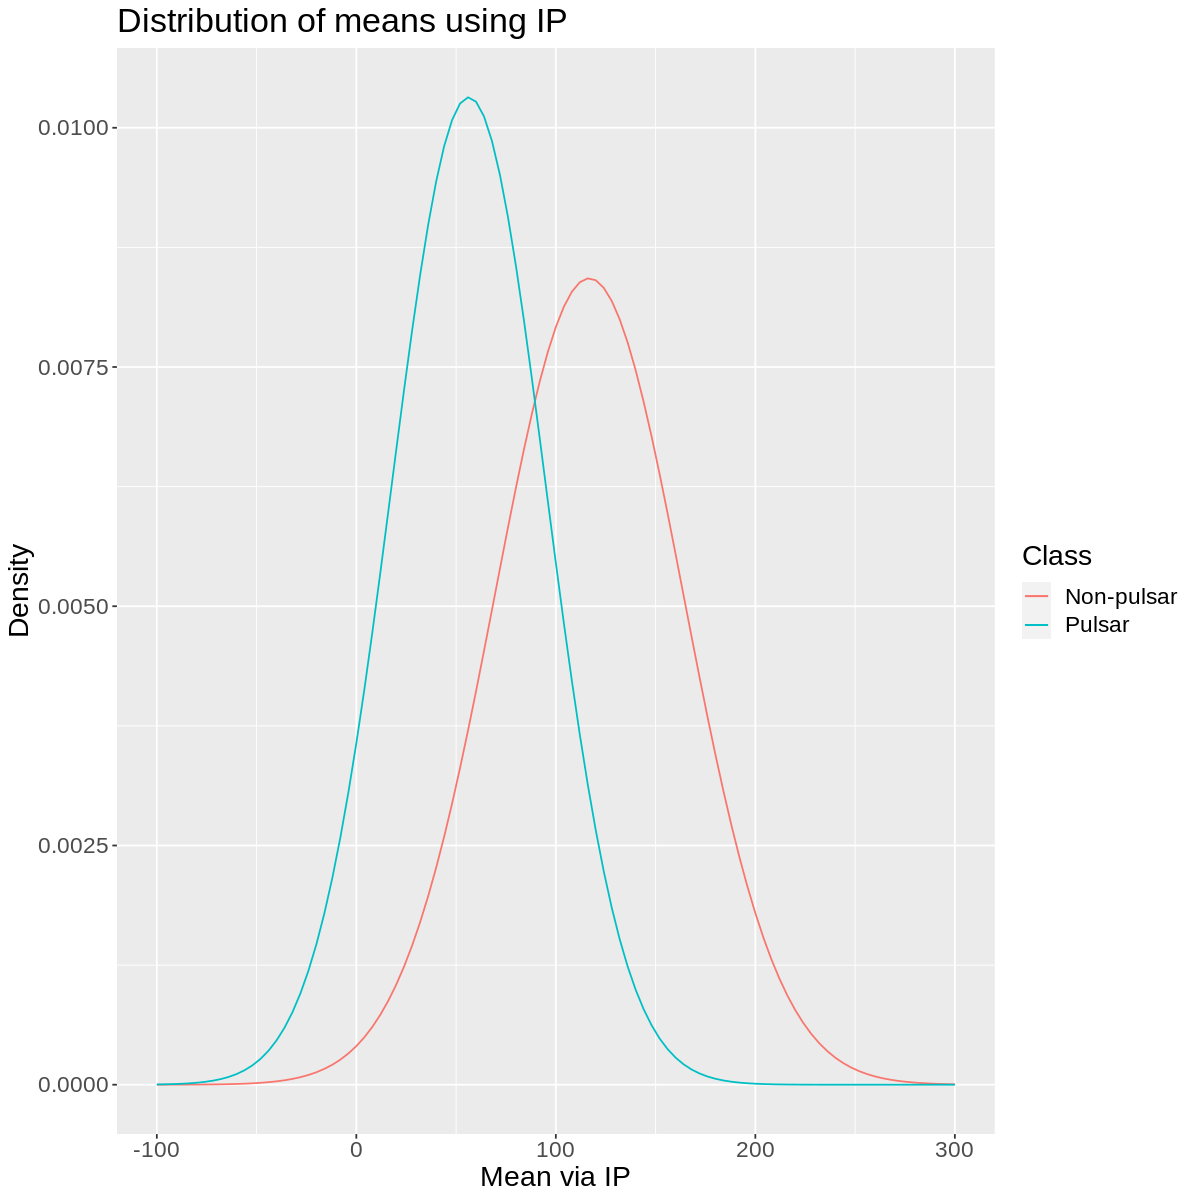

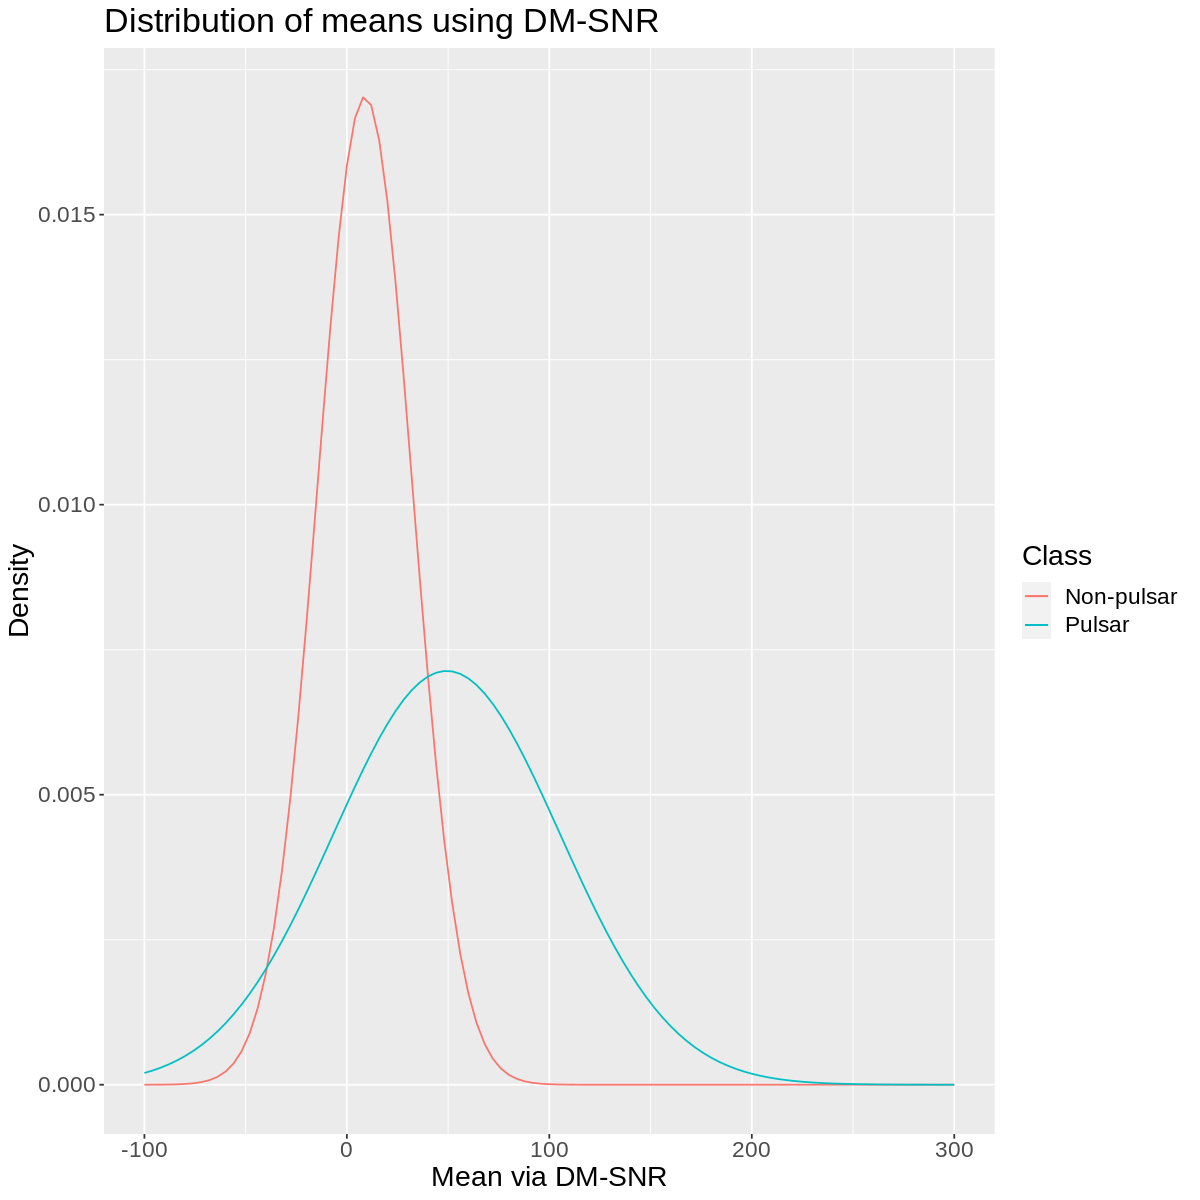

In [6]:
#We visualized the curve of the average mean of the integrated pulse profile, 
# and the DM-SNR profile for positive and negative pulsar stars.
options(repr.plot.width = 10, repr.plot.height = 10) 

IP_distribution <- ggplot() + 
  lapply(split(IP_train_summary, seq_len(nrow(IP_train_summary))), 
         \(x) stat_function(fun = dnorm, 
                            args = list(mean = x$avg_mean_ip, sd = x$avg_stdev_ip), 
                            aes(color = factor(x$Class)))) +
  theme(text = element_text(size = 17)) +
  xlim(-100,300)+
    labs(x = 'Mean via IP', y = 'Density', color = 'Class', 
         title = 'Distribution of means using IP')
IP_distribution

DM_distribution <- ggplot() + 
  lapply(split(DM_train_summary, seq_len(nrow(DM_train_summary))), 
         \(x) stat_function(fun = dnorm, 
                            args = list(mean = x$avg_mean_dm, sd = x$avg_stdev_dm), 
                            aes(color = factor(x$Class)))) +
  theme(text = element_text(size = 17)) +
  xlim(-100,300)+
    labs(x = 'Mean via DM-SNR', y = 'Density', color = 'Class', 
         title = 'Distribution of means using DM-SNR')
DM_distribution 
                                           

## Methods

1. Creating 2 data groups:
   - Group 1: Integrated profile columns Mean_IP, Stdev_IP, Kurtosis_IP and Skewness_IP will be used to predict the Class
   - Group 2: DM-SNR profile columns Mean_DM, Stdev_DM, Kurtosis_DM and Skewness_DM will be used to predict the Class
2. Oversampling: When running knn we will use the oversampling technique since positive cases are very few compared to negative cases ((1,639 positive examples (9.16%) and 16,259 negative examples (90.85%)).
3. We will also standardize our variables.
4. Training the classification KNN models
5. Tuning the models
6. Testing the models 
7. Evaluating the models via confusion matrices and accuracy estimates
8. Picking the best classification model to predict pulsar stars based on background information.
For example, if it is more costly to investigate a false positive, we would want to choose a model with high accuracy and a low rate of false positives.



### Visualizing the results

We will visualize the results with a bar graph comparing the accuracies of each prediction model we created. 

## Hypothesis: 

To make a hypothesis on which profile is better at predicting pulsar star class, we computed if the difference in means between pulsar and non-pulsar stars is significant for both profiles. Although both profiles are effective at telling a pulsar and non-pulsar star apart (p < 0.05), the integrated profile has a larger difference between the mean of pulsar and non-pulsar (larger t).

**We hypothesize that using the integrated profile versus the DM-SNR profile will provide more accurate predictions of pulsar star class.**

In [7]:
set.seed(0)

integrated_pulsar <- rnorm(1639, mean = 56.69061, sd = 38.71060)
integrated_non_pulsar <- rnorm(16259, mean= 116.56273, sd = 47.33974)

integrated_profile_t_test_result <- t.test(integrated_non_pulsar, integrated_pulsar, alternative = "two.sided", var.equal = TRUE)
integrated_profile_t_test_result

DM_pulsar <- rnorm(1639, mean = 8.863258, sd = 23.28798)
DM_non_pulsar <- rnorm(16259, mean= 49.825995, sd = 56.46896)

DM_profile_t_test_result <- t.test(DM_non_pulsar, DM_pulsar, alternative = "two.sided", var.equal = TRUE)
DM_profile_t_test_result


	Two Sample t-test

data:  integrated_non_pulsar and integrated_pulsar
t = 50.911, df = 17896, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 59.02770 63.75493
sample estimates:
mean of x mean of y 
117.04144  55.65013 



	Two Sample t-test

data:  DM_non_pulsar and DM_pulsar
t = 29.638, df = 17896, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 39.29613 44.86195
sample estimates:
mean of x mean of y 
50.180184  8.101145 


## Conclusion: 

Investigating which profile best predicts the class of a pulsar star can help us to better understand and identify these cosmic phenomena. Thus, this leads us to future questions such as: if a pulsar star has been identified, what is the correlation of its findings to other cosmic phenomena such as dark matter and gravity waves? 